In [1]:
#!pip install openpyxl --upgrade --pre

In [2]:
import os
import regex as re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation

sw = stopwords.words("english")
import openpyxl

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report 
from sklearn.linear_model import LogisticRegression 
import seaborn as sns 
import matplotlib.pyplot as plt 
import warnings 
warnings.filterwarnings('ignore')

import string
from nltk.tokenize import word_tokenize 

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  

import wordcloud
from wordcloud import WordCloud

/Users/travis/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/travis/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [3]:
# Add any additional import statements you need here
import html
from textacy import preprocessing
import string
import nltk

stop_words = set(stopwords.words("english"))

/Users/travis/opt/anaconda3/lib/python3.8/site-packages/h5py/__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters


In [4]:
df = pd.read_excel('reddit-data.xlsx')
df

,Unnamed: 0,subreddit,text
0,0,personalfinance,"# Welcome! Before making a post, please check..."
1,1,personalfinance,"### If you need help, please check the [PF Wik..."
2,2,personalfinance,Haven't been churning so much lately; but foun...
3,3,personalfinance,**TL;DR** my question is: If I set up a 529 Sa...
4,4,personalfinance,"I've lived in my house in VA since 2009, and a..."
...,...,...,...
4768,895,story,Do you ever make up stories that are so absurd...
4769,896,story,"So up until about 2019, I was unable to watch ..."
4770,897,story,I had to shit at the airport (I couldn't shit ...
4771,898,story,"This morning as I was grabbing my right shoe, ..."


In [5]:
print(df['text'])

0       # Welcome!  Before making a post, please check...
1       ### If you need help, please check the [PF Wik...
2       Haven't been churning so much lately; but foun...
3       **TL;DR** my question is: If I set up a 529 Sa...
4       I've lived in my house in VA since 2009, and a...
                              ...                        
4768    Do you ever make up stories that are so absurd...
4769    So up until about 2019, I was unable to watch ...
4770    I had to shit at the airport (I couldn't shit ...
4771    This morning as I was grabbing my right shoe, ...
4772         **True peace is only won by peaceful means**
Name: text, Length: 4773, dtype: object


In [6]:
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """

    # Fill in the correct values here. 
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens/num_tokens
    num_characters = 0
    for i in tokens:
        num_characters += len(i)
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])
    

In [7]:
text = "here is some example text with other example text here in this text".split()
assert(descriptive_stats(text, verbose=True)[0] == 13)
assert(descriptive_stats(text, verbose=False)[1] == 9)
assert(abs(descriptive_stats(text, verbose=False)[2] - 0.69) < 0.02)
assert(descriptive_stats(text, verbose=False)[3] == 55)


There are 13 tokens in the data.
There are 9 unique tokens in the data.
There are 55 characters in the data.
The lexical diversity is 0.692 in the data.


In [8]:
# create your clean twitter data here

## This calculates the impurity in an instance of tokens, used to find characters worth removing
RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')
def impurity(text, min_len=10):
    """returns the share of suspicious characters in a text""" 
    if text == None or len(text) < min_len:
        return 0 
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)
    print(impurity(text))

## Function to clean the text by removing matches on the regex rules
def clean(text):
    # convert html escapes like &amp; to characters.
    text = html.unescape(text)
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text) # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'##',' ',text)
    text = re.sub(r'{{_}}',' ',text)
    text = re.sub(r'/\/',' ',text)
    text = re.sub(r'//\\',' ',text)
    text = re.sub(r'\\',' ',text)
    #Remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text)
    return text.strip()

def normalize(text):
    text = preprocessing.normalize.hyphenated_words(text)
    text = preprocessing.normalize.quotation_marks(text)
    text = preprocessing.normalize.unicode(text)
    text = preprocessing.remove.accents(text)
    return text


def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stop_words]

pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline): 
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [9]:
df['text'] = df['text'].astype('string')

In [10]:
df['text'] = df['text'].fillna('')

In [11]:
df['clean_text'] = df['text'].map(clean)
df['clean_text'] = df['clean_text'].astype('string')
df['clean_text'] = df['clean_text'].map(normalize)
df['tokens'] = df['clean_text'].apply(prepare, pipeline=pipeline)
df.head()

,Unnamed: 0,subreddit,text,clean_text,tokens
0,0,personalfinance,"# Welcome! Before making a post, please check...",Welcome Before making a post please check ou...,"[welcome, making, post, please, check, great, ..."
1,1,personalfinance,"### If you need help, please check the [PF Wik...",If you need help please check the PF Wiki to ...,"[need, help, please, check, pf, wiki, see, que..."
2,2,personalfinance,Haven't been churning so much lately; but foun...,Haven t been churning so much lately but foun...,"[churning, much, lately, found, make, mortgage..."
3,3,personalfinance,**TL;DR** my question is: If I set up a 529 Sa...,TL DR my question is If I set up a 529 Savi...,"[tl, dr, question, set, savings, account, niec..."
4,4,personalfinance,"I've lived in my house in VA since 2009, and a...",I ve lived in my house in VA since 2009 and a...,"[lived, house, va, since, along, years, house,..."


In [12]:
posts = []
for description in df["clean_text"]:
    posts.extend(description.split())

In [13]:
print('Subreddit Descriptive Statistics')
print(descriptive_stats(posts))

Subreddit Descriptive Statistics
There are 1042337 tokens in the data.
There are 35401 unique tokens in the data.
There are 4201232 characters in the data.
The lexical diversity is 0.034 in the data.
[1042337, 35401, 0.0339631040632732, 4201232]


In [14]:
if 'Unnamed: 0' in df: 
    df.drop('Unnamed: 0',axis=1,inplace=True)

In [15]:
df

,subreddit,text,clean_text,tokens
0,personalfinance,"# Welcome! Before making a post, please check...",Welcome Before making a post please check ou...,"[welcome, making, post, please, check, great, ..."
1,personalfinance,"### If you need help, please check the [PF Wik...",If you need help please check the PF Wiki to ...,"[need, help, please, check, pf, wiki, see, que..."
2,personalfinance,Haven't been churning so much lately; but foun...,Haven t been churning so much lately but foun...,"[churning, much, lately, found, make, mortgage..."
3,personalfinance,**TL;DR** my question is: If I set up a 529 Sa...,TL DR my question is If I set up a 529 Savi...,"[tl, dr, question, set, savings, account, niec..."
4,personalfinance,"I've lived in my house in VA since 2009, and a...",I ve lived in my house in VA since 2009 and a...,"[lived, house, va, since, along, years, house,..."
...,...,...,...,...
4768,story,Do you ever make up stories that are so absurd...,Do you ever make up stories that are so absurd...,"[ever, make, stories, absurd, tell, people, be..."
4769,story,"So up until about 2019, I was unable to watch ...",So up until about 2019 I was unable to watch ...,"[unable, watch, movie, every, time, watched, i..."
4770,story,I had to shit at the airport (I couldn't shit ...,I had to shit at the airport I couldn t shit ...,"[shit, airport, shit, anywhere, nervous, choic..."
4771,story,"This morning as I was grabbing my right shoe, ...",This morning as I was grabbing my right shoe ...,"[morning, grabbing, right, shoe, noticed, damp..."


# Models

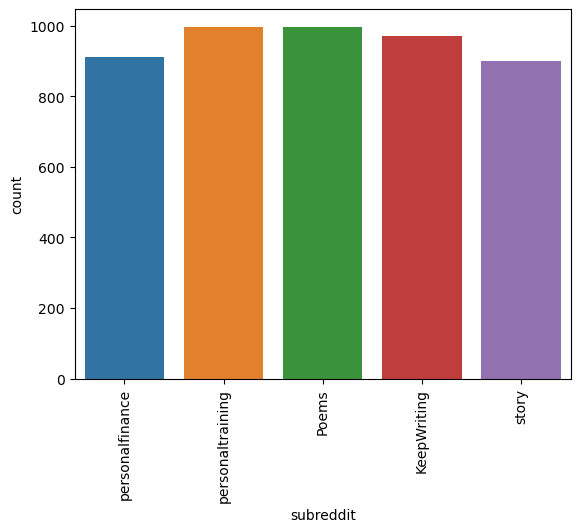

In [16]:
sns.countplot(df['subreddit']) 
plt.xticks(rotation=90) 
plt.show()

In [17]:
labels = ['Poems', 'personaltraining', 'KeepWriting', 'personalfinance', 'story'] 
 
def plot_cm(confusion_mat): 
    df_cm = pd.DataFrame(confusion_mat, index = labels, 
                      columns = labels) 
    plt.figure(figsize = (10,7)) 
    sns.heatmap(df_cm, annot=True) 
    plt.xticks(rotation=90) 
    plt.yticks(rotation=0) 
    plt.show()

## Implement CountVectorizer to convert text to vectors

In [18]:
df['tokens_joined'] = df['tokens'].apply(lambda x: ' '.join(x))

In [19]:
X = df['tokens_joined'] 
y = df['subreddit']

In [20]:
# train test split 
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.25, random_state = 40)

In [21]:
cv = CountVectorizer(ngram_range =(2,2), max_features = 20000) 
X_train_cv = cv.fit_transform(X_train).toarray() 
X_test_cv = cv.transform(X_test) 
X_train_cv

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Logistic Regression

In [22]:
lr_classifier = LogisticRegression(n_jobs=-1) 
lr_classifier.fit(X_train_cv, y_train)

LogisticRegression(n_jobs=-1)

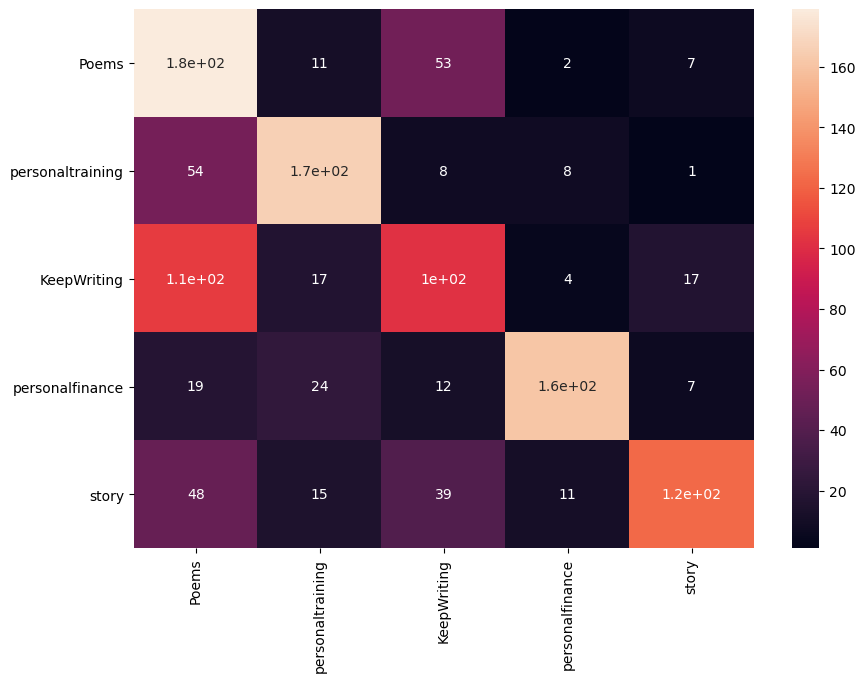

In [23]:
lr_y_pred = lr_classifier.predict(X_test_cv) 
confusion_mat = confusion_matrix(y_test, lr_y_pred,labels=labels) 
plot_cm(confusion_mat)

In [24]:
print(classification_report(y_test,lr_y_pred))

                  precision    recall  f1-score   support

     KeepWriting       0.48      0.41      0.44       246
           Poems       0.44      0.71      0.54       252
 personalfinance       0.87      0.72      0.79       223
personaltraining       0.71      0.70      0.71       237
           story       0.79      0.52      0.63       236

        accuracy                           0.61      1194
       macro avg       0.66      0.61      0.62      1194
    weighted avg       0.65      0.61      0.62      1194



In [25]:
print(accuracy_score(y_test,lr_y_pred))

0.6122278056951423


## Random Forest Classifier

In [26]:
rf_classifier = RandomForestClassifier(n_jobs=-1,verbose=2,n_estimators=20) 
rf_classifier.fit(X_train_cv, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 20building tree 2 of 20

building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:    5.6s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    7.9s finished


RandomForestClassifier(n_estimators=20, n_jobs=-1, verbose=2)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  20 out of  20 | elapsed:    0.0s finished


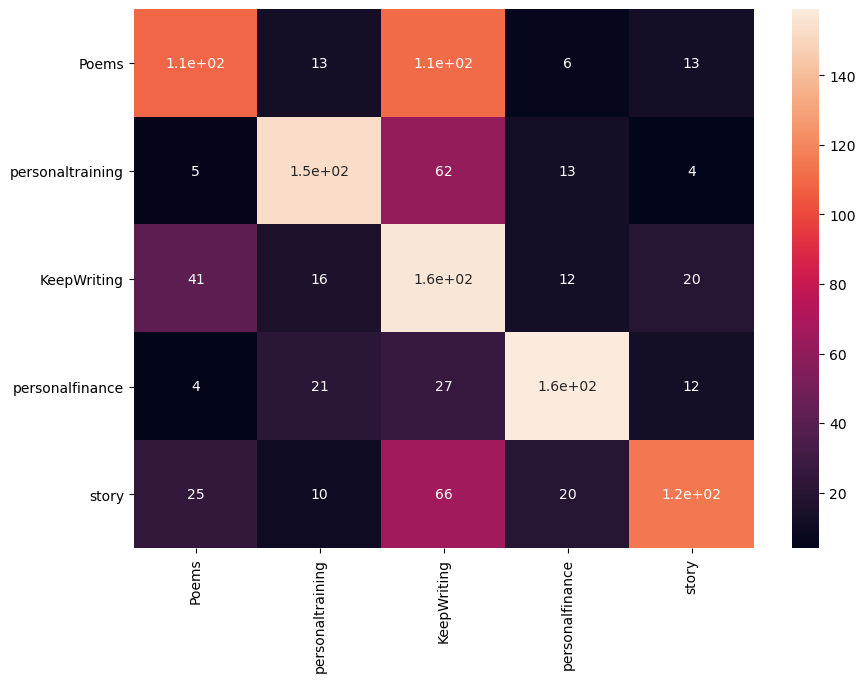

In [27]:
rf_y_pred = rf_classifier.predict(X_test_cv) 
confusion_mat = confusion_matrix(y_test, rf_y_pred,labels=labels) 
plot_cm(confusion_mat)

In [28]:
print(classification_report(y_test,rf_y_pred))

                  precision    recall  f1-score   support

     KeepWriting       0.37      0.64      0.47       246
           Poems       0.59      0.43      0.50       252
 personalfinance       0.76      0.71      0.73       223
personaltraining       0.72      0.65      0.68       237
           story       0.70      0.49      0.57       236

        accuracy                           0.58      1194
       macro avg       0.63      0.58      0.59      1194
    weighted avg       0.62      0.58      0.59      1194



In [29]:
print(accuracy_score(y_test,rf_y_pred))

0.5804020100502513


## Implement TfIdfVectorizer to convert text tovector

In [30]:
tfidf = TfidfVectorizer(ngram_range =(2,2)) 
X_train_tfidf = tfidf.fit_transform(X_train).toarray()  
X_test_tfidf = tfidf.transform(X_test) 
X_train_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Logistic Regression

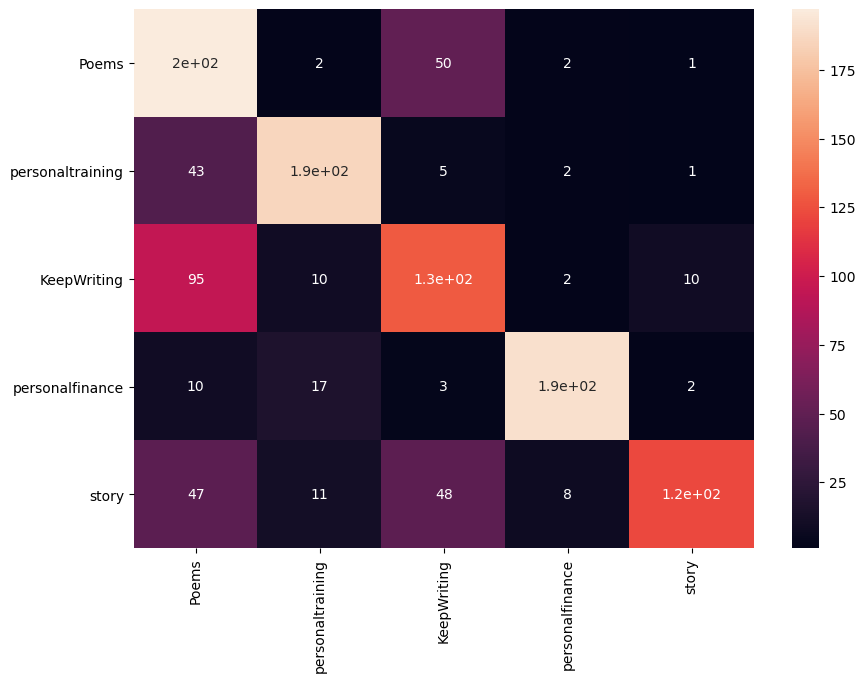

In [31]:
lr_classifier = LogisticRegression() 
lr_classifier.fit(X_train_tfidf, y_train) 
 
lr_y_pred = lr_classifier.predict(X_test_tfidf) 
confusion_mat = confusion_matrix(y_test, lr_y_pred,labels=labels) 
plot_cm(confusion_mat)

In [32]:
print(classification_report(y_test,lr_y_pred))

                  precision    recall  f1-score   support

     KeepWriting       0.55      0.52      0.54       246
           Poems       0.50      0.78      0.61       252
 personalfinance       0.93      0.86      0.89       223
personaltraining       0.82      0.78      0.80       237
           story       0.90      0.52      0.66       236

        accuracy                           0.69      1194
       macro avg       0.74      0.69      0.70      1194
    weighted avg       0.73      0.69      0.70      1194



In [33]:
print(accuracy_score(y_test,lr_y_pred))

0.6909547738693468


## Random Forest Classifier

In [34]:
rf_classifier = RandomForestClassifier(n_jobs=-1,verbose=2,n_estimators=20) 
rf_classifier.fit(X_train_tfidf, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 20building tree 2 of 20
building tree 3 of 20

building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:   44.9s remaining:   36.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.0min finished


RandomForestClassifier(n_estimators=20, n_jobs=-1, verbose=2)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  20 out of  20 | elapsed:    0.0s finished


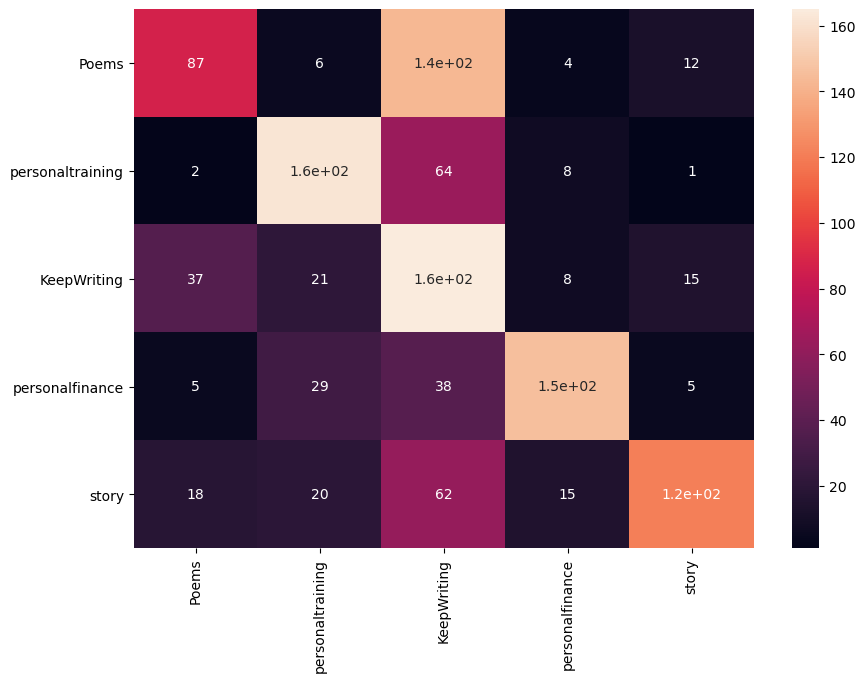

In [35]:
rf_y_pred = rf_classifier.predict(X_test_tfidf) 
confusion_mat = confusion_matrix(y_test, rf_y_pred,labels=labels) 
plot_cm(confusion_mat) 

In [36]:
print(classification_report(y_test,rf_y_pred))

                  precision    recall  f1-score   support

     KeepWriting       0.35      0.67      0.46       246
           Poems       0.58      0.35      0.43       252
 personalfinance       0.81      0.65      0.72       223
personaltraining       0.68      0.68      0.68       237
           story       0.79      0.51      0.62       236

        accuracy                           0.57      1194
       macro avg       0.64      0.57      0.58      1194
    weighted avg       0.64      0.57      0.58      1194



In [37]:
print(accuracy_score(y_test,rf_y_pred))

0.5703517587939698


## LDA

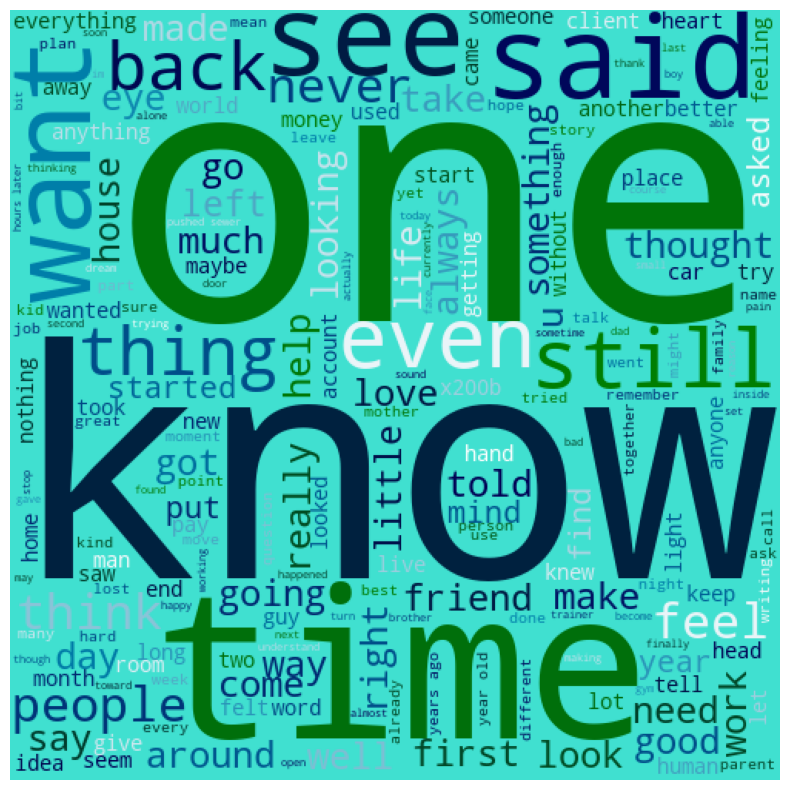

In [38]:

#combine all the articles
article_data = ""
for text in X:
    article_data = article_data+" "+text

#ploting the word cloud
plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width = 500, height = 500, background_color='#40E0D0', colormap="ocean",  random_state=10).generate(article_data)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [39]:
full_corpus = []
for i in df['tokens']:
    full_corpus.append(i)

In [40]:
from gensim.corpora.dictionary import Dictionary
import warnings
warnings.filterwarnings('ignore')

# from gensim.models.ldamodel import LdaModel

# Create a corpus from a list of texts
id2word = Dictionary(full_corpus)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in full_corpus]

In [41]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           minimum_phi_value = 0.01,
                                           alpha='symmetric',
                                           per_word_topics=True,
                                           eta = 0.6)

In [42]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.027*"sewer" + 0.021*"carmen" + 0.018*"pushed" + 0.014*"repost" + '
  '0.012*"shower" + 0.012*"jessica" + 0.011*"went" + 0.010*"neck" + '
  '0.010*"broke" + 0.010*"girls"'),
 (1,
  '0.022*"human" + 0.017*"humans" + 0.010*"com" + 0.008*"https" + '
  '0.008*"audiobook" + 0.006*"www" + 0.005*"paperback" + 0.005*"weird" + '
  '0.004*"steve" + 0.004*"ebook"'),
 (2,
  '0.010*"like" + 0.008*"one" + 0.008*"said" + 0.008*"would" + 0.007*"time" + '
  '0.007*"know" + 0.007*"get" + 0.006*"back" + 0.006*"got" + 0.005*"go"'),
 (3,
  '0.010*"max" + 0.006*"li" + 0.005*"shiki" + 0.004*"bank" + 0.004*"chi" + '
  '0.004*"chong" + 0.003*"cb" + 0.003*"tracy" + 0.003*"account" + '
  '0.002*"money"'),
 (4,
  '0.008*"eyes" + 0.005*"back" + 0.005*"door" + 0.004*"like" + 0.004*"face" + '
  '0.004*"light" + 0.004*"one" + 0.004*"man" + 0.004*"see" + 0.003*"away"')]


In [43]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.232496 -0.095921       1        1  62.576205
4     -0.054963 -0.131227       2        1  20.592860
3      0.162269 -0.033227       3        1   7.447517
0     -0.065621  0.287813       4        1   6.418766
1      0.190811 -0.027439       5        1   2.964652, topic_info=         Term         Freq        Total Category  logprob  loglift
1081     went  1741.000000  1741.000000  Default  30.0000  30.0000
10044   sewer   827.000000   827.000000  Default  29.0000  29.0000
17608  carmen   664.000000   664.000000  Default  28.0000  28.0000
168    school  1377.000000  1377.000000  Default  27.0000  27.0000
3621   pushed   650.000000   650.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
1703    weird    71.566050   423.758474   Topic5  -5.3002   1.7399
3276     book    50.606716   226.744092   Topic5  -5.6468   2.0187
7595     blog    33.475224    74.882947   Topic5  -6.0600   2.7133
16063   trump    35.558850   104.114662   Topic5  -5.9997   2.4441
25       post    31.152057   402.661755   Topic5  -6.1320   0.9592

[318 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
110        1  0.584152        account
110        2  0.004264        account
110        3  0.413597        account
6319       1  0.047691  administrator
6319       2  0.015897  administrator
...      ...       ...            ...
2416       3  0.046523          youtu
2416       5  0.930466          youtu
23395      1  0.036484         zariel
23395      2  0.218903         zariel
23395      3  0.729675         zariel

[894 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 4, 1, 2])

### Looking for a high coherence score

In [ ]:
# Compute Perplexity
print('\nPerplexity : ', lda_model.log_perplexity(corpus)) 

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=full_corpus, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)